### Import packages and define functions for calculations

In [1]:
'''Import packages for loading data, analysing, and plotting'''

import xarray
import numpy
import cartopy
import matplotlib
%matplotlib inline

# Add a couple of deep down individual functions.
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import AutoMinorLocator

# used to create area averages over AR6 regions.
import regionmask

# hide some warning messages
import warnings
warnings.filterwarnings("ignore")


# Computing and plotting the tas timeseries under ssp126 &ssp585 scenario & historical runs directly from UKESM1 output

In [8]:
# Download and load the historical/ssp126 UKESM1 output
# then combine then into one single file which covers the time period from 1850-2100

filename_hist_1='~/geog0121_shared_space/cmip6_UKESM1_data/historical/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
filename_hist_2='~/geog0121_shared_space/cmip6_UKESM1_data/historical/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc'

filename_ssp126_1='~/geog0121_shared_space/cmip6_UKESM1_data/ssp126/tas_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_201501-204912.nc'
filename_ssp126_2='~/geog0121_shared_space/cmip6_UKESM1_data/ssp126/tas_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_205001-210012.nc'

filename_ssp585_1='~/geog0121_shared_space/cmip6_UKESM1_data/ssp585/tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912.nc'
filename_ssp585_2='~/geog0121_shared_space/cmip6_UKESM1_data/ssp585/tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012.nc'

In [20]:
historical=xarray.open_mfdataset(paths=[filename_hist_1,filename_hist_2],combine='by_coords')
tas_hist=historical.tas #just select the surface air temperatures

ssp126=xarray.open_mfdataset(paths=[filename_ssp126_1,filename_ssp126_2],combine='by_coords')
tas_126=ssp126.tas #just select the surface air temperatures

ssp585=xarray.open_mfdataset(paths=[filename_ssp585_1,filename_ssp585_2],combine='by_coords')
tas_585=ssp585.tas #just select the surface air temperatures

<xarray.DataArray 'tas' (time: 1032, lat: 144, lon: 192)>
dask.array<where, shape=(1032, 144, 192), dtype=float32, chunksize=(611, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 1.5
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-04-18T14:32:46Z altered by CMOR: Treated scalar dime...

In [18]:
#Set as anomalies from 1981-2010
baseline=tas_hist.sel(time=slice('1981-01-01', '2010-12-30'))
climatology = baseline.groupby("time.month").mean("time")
tasA_hist = tas_hist.groupby("time.month") - climatology
tasA_126 = tas_126.groupby("time.month") - climatology
tasA_585 = tas_585.groupby("time.month") - climatology
tasA_585

<xarray.DataArray 'tas' (time: 1032, lat: 144, lon: 192)>
dask.array<getitem, shape=(1032, 144, 192), dtype=float32, chunksize=(1, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 1.5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [13]:
# create some area-weights to average the fields with
weights=tas_hist[0,:,:] #using tas to copy over metadata  #select the 1st timestep
weights = numpy.cos(numpy.deg2rad(historical.lat))
weights.name = "weights"
    
#Make some field with the weighting applied
tasA_wgtd_hist=tasA_hist.weighted(weights)
tasA_wgtd_126=tasA_126.weighted(weights)
tasA_wgtd_585=tasA_585.weighted(weights)

In [34]:
#Create the global mean temperatures...
gmt_hist = tasA_wgtd_hist.mean(dim=('lat', 'lon'))
gmt_126 = tasA_wgtd_126.mean(dim=('lat', 'lon'))
gmt_585 = tasA_wgtd_585.mean(dim=('lat', 'lon'))
gmt_hist

<xarray.DataArray (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
    height   float64 1.5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [38]:
#Create some 5 year smoothed versions (60 months)
gmt_hist=gmt_hist.chunk(1980) #re-chunking array to avoid error on next line
gmt_hist_smoothed=gmt_hist.rolling(time=60,center=True).mean(dim=('time'))
gmt_126=gmt_126.chunk(1032) #re-chunking time series into single long block to avoid error on next line
gmt_126_smoothed=gmt_126.rolling(time=60,center=True).mean(dim=('time'))
gmt_585=gmt_585.chunk(1032) #re-chunking all months into single long block to avoid error on next line
gmt_585_smoothed=gmt_585.rolling(time=60,center=True).mean(dim=('time'))

Text(0.5, 1.0, 'GMST')

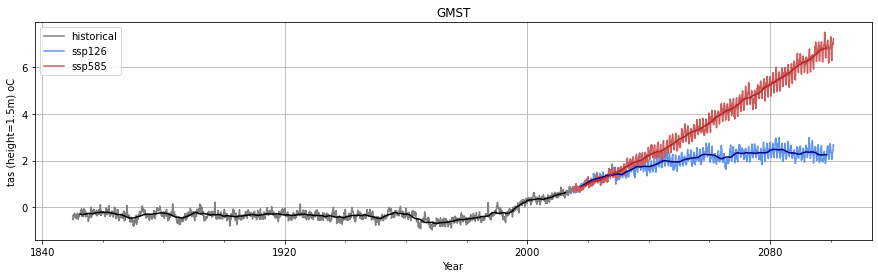

In [40]:
# Create a line plot of monthly global mean surface temperature anomalies
fig, ax = matplotlib.pyplot.subplots(figsize=(15,4))
gmt_hist.plot(ax=ax, label='historical',color='grey')
gmt_126.plot(ax=ax, label='ssp126',color='cornflowerblue')
gmt_585.plot(ax=ax, label='ssp585',color='indianred')
gmt_126_smoothed.plot(ax=ax,color='navy')
gmt_hist_smoothed.plot(ax=ax,color='black')
gmt_585_smoothed.plot(ax=ax,color='firebrick')
ax.grid()
ax.xaxis.set_minor_locator(AutoMinorLocator())   
ax.legend(loc='best') 
ax.set(xlabel='Year',ylabel='tas (height=1.5m) oC')
matplotlib.pyplot.title('GMST')

# The Ocean Grid

Working with model output on the ocean grid, with its rotated pole, presents an additional challenge. You must use the advanced features of `cartopy`, which comes bundeled with both the `geog0121` and `geog0111` virtual environments on the JupyterHub, but may not available elsewhere.

## Sea surface temperature

In [2]:
variable_name='tos'
filename_a='~/geog0121_shared_space/cmip6_UKESM1_data/historical/tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
filename_b='~/geog0121_shared_space/cmip6_UKESM1_data/ssp370/tos_Omon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc'

In [3]:
#Load in the data
expt_a_file=xarray.open_dataset(filename_a,decode_times=False)
expt_a=expt_a_file[variable_name]

expt_b_file=xarray.open_dataset(filename_b,decode_times=False)
expt_b=expt_b_file[variable_name]

#2D coordinates
latitude=expt_a_file['latitude']
longitude=expt_a_file['longitude']

In [4]:
# Now we take the time-averages
mn_a=numpy.average(expt_a,axis=0)
mn_b=numpy.average(expt_b,axis=0)

diff=mn_b-mn_a

Having now created the field to actually plot, let's get on doing so

In [5]:
#temperatures
cmap=matplotlib.pyplot.get_cmap('bwr') #define colormap

#define colormap's range and scale
clim=[-6,6]
bounds = numpy.linspace(clim[0], clim[1], 21)
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

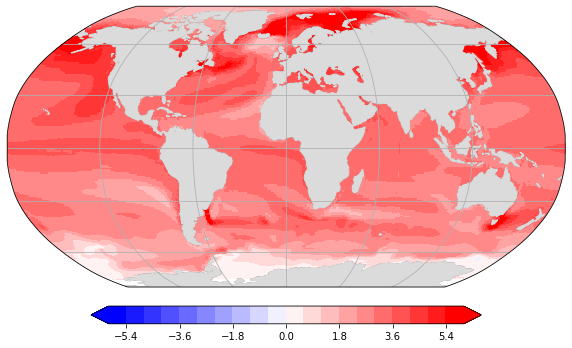

In [6]:
#Global map

projection = cartopy.crs.Robinson()
transform=cartopy.crs.PlateCarree()

matplotlib.pyplot.figure(figsize=(10,7))
ax = matplotlib.pyplot.axes(projection=projection)

ax.coastlines(resolution='110m', linewidth=0.5)
ax.gridlines()

fig=ax.pcolormesh(longitude,latitude,diff,transform=transform,cmap=cmap,norm=norm,shading="flat")
ax.add_feature(cartopy.feature.LAND, zorder=1,facecolor=cartopy.feature.COLORS['land_alt1'])
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
matplotlib.pyplot.colorbar(fig,cax=cax,extend='both',**kw)

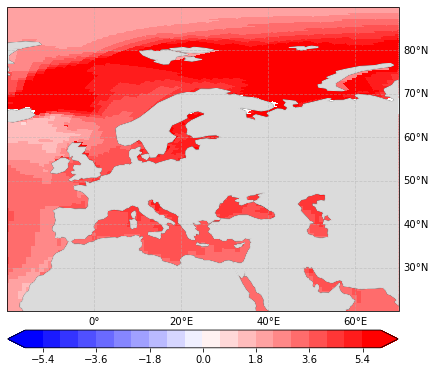

In [7]:
#Regional map
region=[-20,70,20,90] #[lon_min,lon_max,lat_min,lat_max]

projection = cartopy.crs.PlateCarree(central_longitude=0.0, globe=None)
transform=cartopy.crs.PlateCarree()

matplotlib.pyplot.figure(figsize=(10,7))
ax = matplotlib.pyplot.axes(projection=projection)

ax.coastlines()
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


fig=ax.pcolormesh(longitude,latitude,diff, transform=transform,cmap=cmap,norm=norm,shading="flat")
ax.add_feature(cartopy.feature.LAND, zorder=1,facecolor=cartopy.feature.COLORS['land_alt1'])
ax.set_extent(region, cartopy.crs.PlateCarree())

cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
matplotlib.pyplot.colorbar(fig,cax=cax,extend='both',**kw)

#matplotlib.pyplot.savefig(figname)

### Machine specific options

This code above is intended to be run on UCL's JupyterHub facility. However it might happen that you need to run this notebook on a different machine. In the cells below, you will find the code to run on the cluster in UCL Geography and on an python installation on your own machine respectively.

In [ ]:
# SST - FOR THE GEOGRAPHY CLUSTER
variable_name='tos'
filename_a='/data/CMIP/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Omon/tos/gn/v20190406/tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
filename_b='/data/CMIP/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r1i1p1f2/Omon/tos/gn/v20190510/tos_Omon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc'

In [ ]:
# SST - FOR YOUR OWN MACHINE
variable_name='tos'
filename_a='Data/tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
filename_b='Data/tos_Omon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc'

#Download the files if they are not already here
import os
import urllib
if not os.path.isfile(filename_a):
    print('Downloading %s' %(filename_a))
    !mkdir Data
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/historical/Omon/tos/gn/v20190406/tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc", filename_a)
    
if not os.path.isfile(filename_b):
    print('Downloading %s' %(filename_b))
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/ssp370/Omon/tos/gn/v20190510/tos_Omon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc", filename_b)    
